# Categorizing and analyzing comments under Recession in 2023 post on Reddit.


Jerin Easo Thomas: jerithom@iu.edu

## Importing the necessary Libraries

In [ ]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords
from scipy.stats import pearsonr
import itertools
import collections

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report,confusion_matrix

from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV, KFold
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
nltk.download("stopwords","wordnet") ## Download the packages Stopwords and wordnet

[nltk_data] Downloading package stopwords to wordnet...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## The Data (Source:- Reddit)

In [ ]:
messages = pd.read_csv('data.csv',error_bad_lines=False)
messages

,Post,Comments,Sentiment,Informative,Geography,Impact,Unrelated Comments
0,"World Economy Is Headed for Recession in 2023,...",This has become a game of semantics. We're in ...,Negative,Yes,USA,Unemployment,No
1,NaN,So you're telling me what we've been going thr...,Negative,Yes,Italy,Economy,No
2,NaN,"Inflation is already heading down, unemploymen...",Negative,Yes,USA,Economy,No
3,NaN,I wish it didn't have to be like this but tbh ...,Positive,Yes,USA,Inflation,No
4,NaN,Absolutely. It's hard to claim recession witho...,Positive,Yes,USA,Unemployment,No
...,...,...,...,...,...,...,...
71,New Zealand forecasts recession in 2023 as it ...,LoL. That is exactly what is going to happen.\...,Negative,Yes,New Zealand,Inflation,No
72,NaN,"Before anyone panics, EU is in stagflation, UK...",Negative,Yes,New Zealand,Economy,No
73,World Bank warns global economy could tip into...,Thanks tips. Havnt hears this type of news onc...,Negative,Yes,Global,Economy,No
74,Chile Recession: Will Chile enter recession in...,Qué miedo da ahora escuchar esa frase. Por qué...,NaN,NaN,NaN,NaN,Yes


In [ ]:
messages[['Comments','Sentiment','Geography ','Impact ']].dropna()

,Comments,Sentiment,Geography,Impact
0,This has become a game of semantics. We're in ...,Negative,USA,Unemployment
1,So you're telling me what we've been going thr...,Negative,Italy,Economy
2,"Inflation is already heading down, unemploymen...",Negative,USA,Economy
3,I wish it didn't have to be like this but tbh ...,Positive,USA,Inflation
4,Absolutely. It's hard to claim recession witho...,Positive,USA,Unemployment
...,...,...,...,...
70,"Yes, they'd rather destroy the whole economy w...",Negative,Global,Inflation
71,LoL. That is exactly what is going to happen.\...,Negative,New Zealand,Inflation
72,"Before anyone panics, EU is in stagflation, UK...",Negative,New Zealand,Economy
73,Thanks tips. Havnt hears this type of news onc...,Negative,Global,Economy


In [ ]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Post                19 non-null     object
 1   Comments            76 non-null     object
 2   Sentiment           72 non-null     object
 3   Informative         71 non-null     object
 4   Geography           73 non-null     object
 5   Impact              71 non-null     object
 6   Unrelated Comments  76 non-null     object
dtypes: object(7)
memory usage: 4.3+ KB


In [ ]:
messages.describe()

,Post,Comments,Sentiment,Informative,Geography,Impact,Unrelated Comments
count,19,76,72,71,73,71,76
unique,19,76,3,1,10,12,2
top,"World Economy Is Headed for Recession in 2023,...",This has become a game of semantics. We're in ...,Negative,Yes,USA,Economy,No
freq,1,1,38,71,24,30,71


In [ ]:
messages['Sentiment'].value_counts()

Negative    38
Positive    28
Neutral      6
Name: Sentiment, dtype: int64

## Exploratory Data Analytics

In [ ]:
messages['length'] = messages['Comments'].apply(len) ## Getting the length of each comment
messages

,Post,Comments,Sentiment,Informative,Geography,Impact,Unrelated Comments,length
0,"World Economy Is Headed for Recession in 2023,...",This has become a game of semantics. We're in ...,Negative,Yes,USA,Unemployment,No,641
1,NaN,So you're telling me what we've been going thr...,Negative,Yes,Italy,Economy,No,451
2,NaN,"Inflation is already heading down, unemploymen...",Negative,Yes,USA,Economy,No,263
3,NaN,I wish it didn't have to be like this but tbh ...,Positive,Yes,USA,Inflation,No,961
4,NaN,Absolutely. It's hard to claim recession witho...,Positive,Yes,USA,Unemployment,No,415
...,...,...,...,...,...,...,...,...
71,New Zealand forecasts recession in 2023 as it ...,LoL. That is exactly what is going to happen.\...,Negative,Yes,New Zealand,Inflation,No,312
72,NaN,"Before anyone panics, EU is in stagflation, UK...",Negative,Yes,New Zealand,Economy,No,189
73,World Bank warns global economy could tip into...,Thanks tips. Havnt hears this type of news onc...,Negative,Yes,Global,Economy,No,60
74,Chile Recession: Will Chile enter recession in...,Qué miedo da ahora escuchar esa frase. Por qué...,NaN,NaN,NaN,NaN,Yes,52


In [ ]:
messages['Impact '].value_counts()

Economy          30
Inflation        12
Unemployment      7
Business          6
Real Estate       5
Technology        3
hospitality       2
Healthcare        2
Stock             1
Entertainment     1
Labour            1
Banking           1
Name: Impact , dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

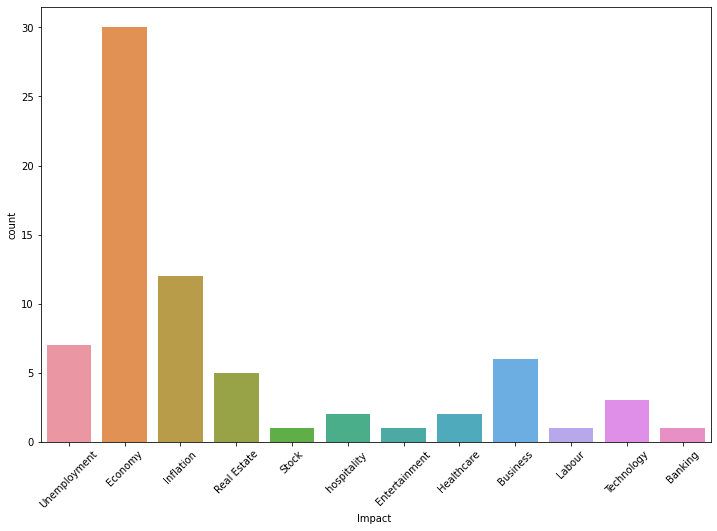

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(messages['Impact '])
plt.annotate()
plt.xticks(rotation = 45)

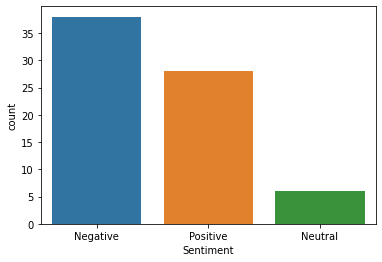

In [ ]:
sns.countplot(messages['Sentiment'])

Text(0.5, 0, 'Length of the Tweets')

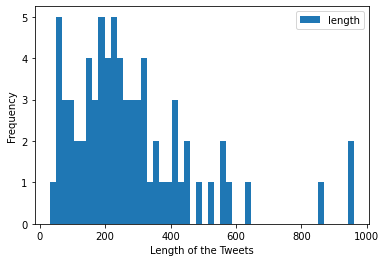

In [ ]:
messages[messages['length']<1000].plot(bins=50, kind='hist') 
plt.xlabel('Length of the Comments')

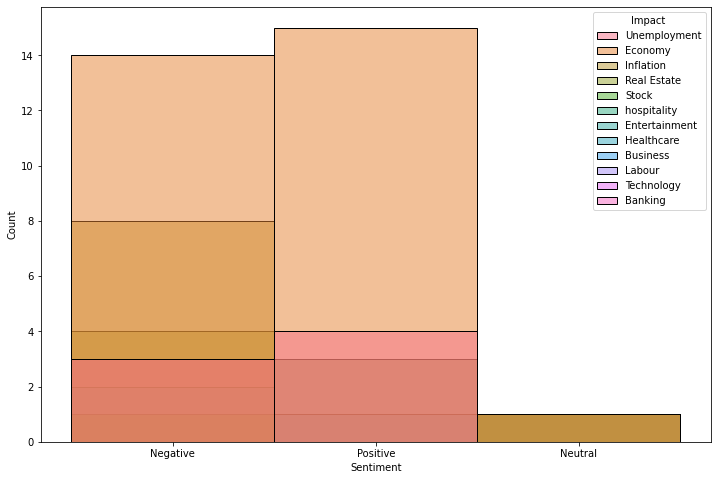

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(data=messages,x='Sentiment',hue='Impact ')

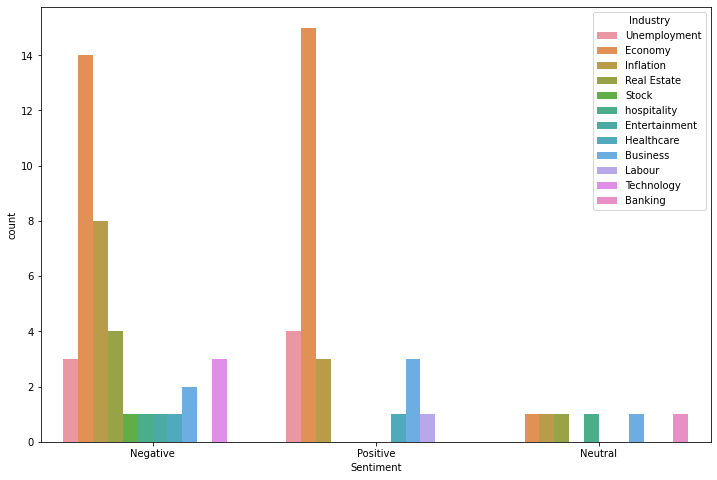

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(data=messages,x='Sentiment',hue='Impact ')
plt.legend(loc='upper right', title='Industry')

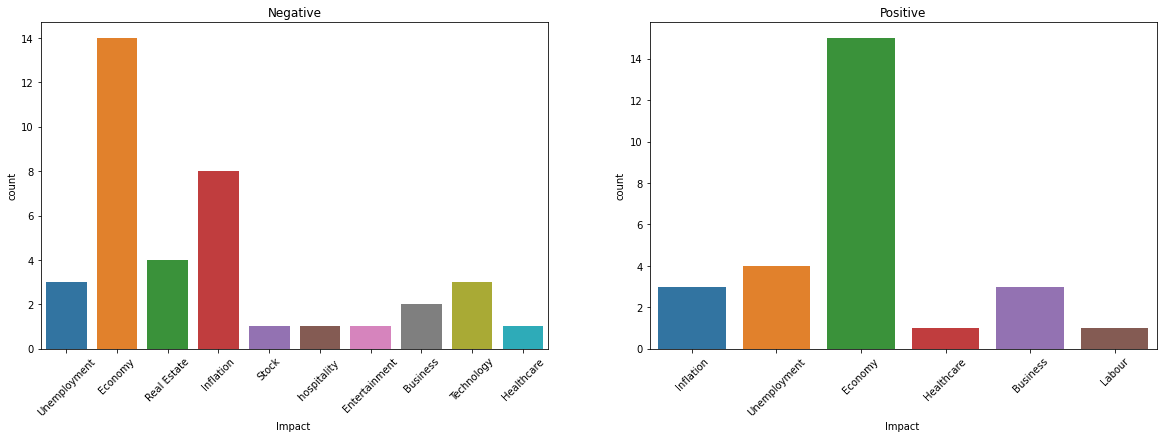

In [ ]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.title('Negative')
plt.xticks(rotation = 45)
sns.countplot(messages[messages['Sentiment']=='Negative']['Impact '])
plt.subplot(1,2,2)
plt.title('Positive')
plt.xticks(rotation = 45)
sns.countplot(messages[messages['Sentiment']=='Positive']['Impact '])

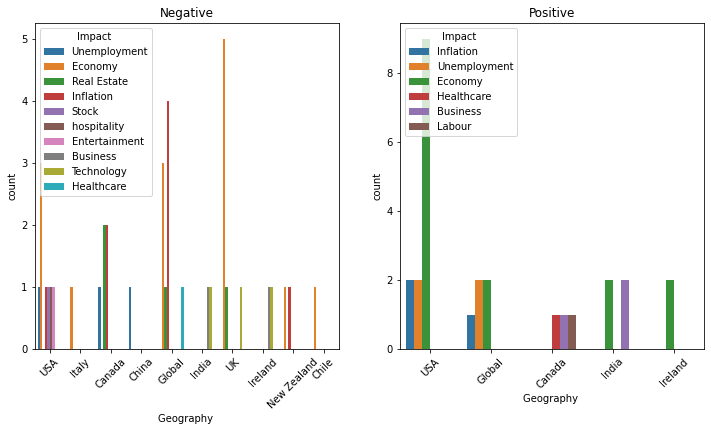

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Negative')
plt.xticks(rotation = 45)
sns.countplot(data=messages[messages['Sentiment']=='Negative'],x='Geography ',hue='Impact ')
plt.subplot(1,2,2)
plt.title('Positive')
plt.xticks(rotation = 45)
sns.countplot(data=messages[messages['Sentiment']=='Positive'],x='Geography ',hue='Impact ')

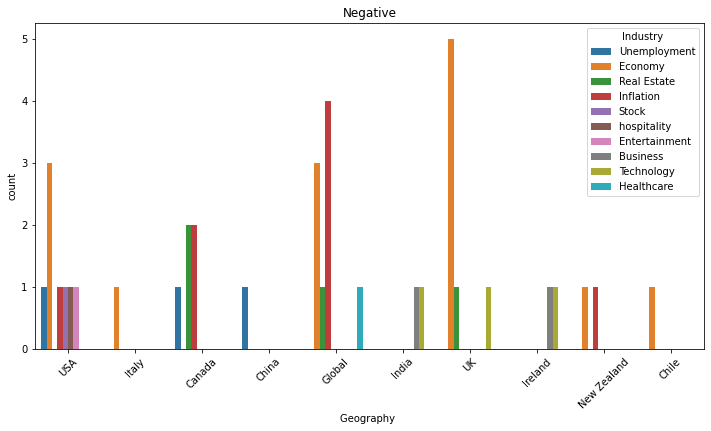

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Negative')
plt.xticks(rotation = 45)
sns.countplot(data=messages[messages['Sentiment']=='Negative'],x='Geography ',hue='Impact ')
plt.legend(loc='upper right',title='Industry')

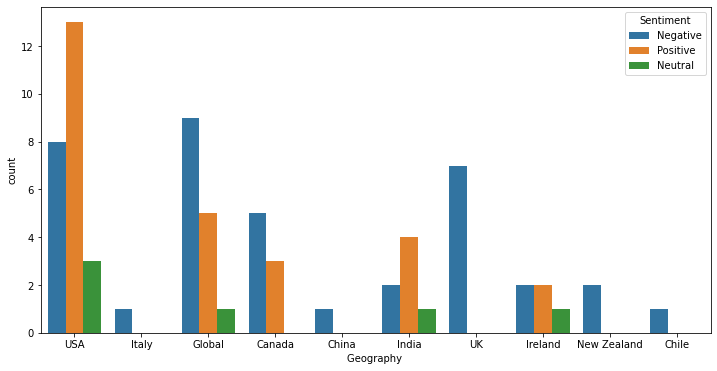

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=messages,x='Geography ',hue='Sentiment')
plt.legend(loc='upper right',title='Sentiment')

In [ ]:
messages[messages['Sentiment']=='Neutral']['Impact ']

12         Economy
15    hospitality 
20       Inflation
31        Business
49     Real Estate
Name: Impact , dtype: object

In [ ]:
messages.length.describe()

count      52.000000
mean      303.153846
std       238.107439
min        31.000000
25%       159.000000
50%       238.500000
75%       355.750000
max      1116.000000
Name: length, dtype: float64

The maximum length of the tweets is 374. Let's see what that tweet is 

In [ ]:
messages[messages['length'] == 1116]['Comments'].iloc[0]

'"and unemployment was allowed to fall so low"\n\nThat\'s it in a nutshell. Business actually likes unemployment as high as 10%. This gives them a large unemployed labour pool in order to suppress wage growth and ensure labour has zero leverage for any gains like working hours, etc etc.\n\nThe looming recession is your fault for having a job.\n\nWhat\'s to blame for inflation and recession? Workers. Plain and simple. You have a job? You\'re to blame. You want a raise? You\'re to blame. You received CERB during the pandemic and it allowed you to not lose your house? You\'re to blame.\n\nBusiness is blameless, always. Record profits are "deserved" and not causing inflation. All input costs must be passed along to consumers, even if there\'s a healthy profit margin that would allow absorption. Profits must always be not only preserved, but rising, or workers are to blame.\n\nRecessions are loved by capital. The price of labour is decreased, asset prices drop and are scooped up by those wi

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f182f2112b0>,
      dtype=object)

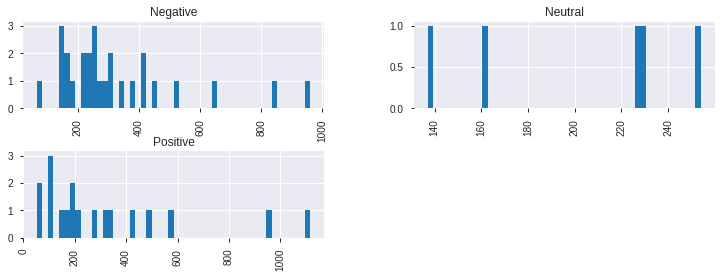

In [ ]:
messages.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

In [ ]:
n = (len(messages[messages['Sentiment'] == 'Negative'])/len(messages))*100
n

51.92307692307693

In [ ]:
p = (len(messages[messages['Sentiment'] == 'Positive'])/len(messages))*100
p

34.61538461538461

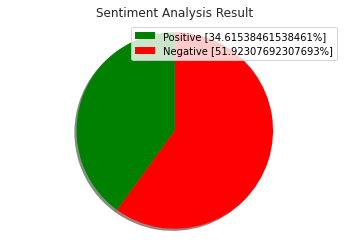

In [ ]:
labels = ['Positive ['+str(p)+'%]' ,'Negative ['+str(n)+'%]']
sizes = [p, n]
colors = ['green','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90,shadow=True)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result")
plt.axis('equal')
plt.show()

In [ ]:
print(pearsonr(messages['length'],messages['Sentiment']))

(-0.011232976285413889, 3.120074564252326e-45)


## Preprocessing of the Data

In [ ]:
messages.drop(['ItemID','SentimentSource'],axis=1,inplace=True)

In [ ]:
messages.head()

,Sentiment,SentimentText,length
0,0,is so sad for my APL frie...,61
1,0,I missed the New Moon trail...,51
2,1,omg its already 7:30 :O,37
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,132
4,0,i think mi bf is cheating on me!!! ...,53


In [ ]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

As the dataset is too big for us to train on our Local Machine we are Slicing the Data

In [ ]:
messages = messages.sample(n=50000)
messages.reset_index(inplace=True)
messages

,index,Sentiment,SentimentText,length
0,260048,0,@kimgasm i wanna visit youuu! I need moneys,44
1,904527,1,I'm in Aldershot waiting for my bestest matey ...,93
2,75295,1,@BTUB40 if I was only a few miles nearer!! Tha...,64
3,1063997,1,@mikerdzign You going next Thursday too? If so...,98
4,1106752,1,no tests,9
...,...,...,...,...
49995,1027209,0,just woke up day off and need to go in to work...,134
49996,679593,0,"Gah, I really hate it when my posts get Stumbl...",116
49997,969885,1,@LAL_rk_JB YAYYYYYYYY!!!!!!!!!!!!! good job la...,52
49998,1275389,0,Trying to focus n do this scholarship but I'm ...,79


In [ ]:
pos = messages[messages['Sentiment'] == 'Positive']['Comments']

In [ ]:
positive = pos.reset_index()['Comments']

In [ ]:
pos_join = []
for i in range(len(positive)):
    sent = re.sub('[^a-zA-Z]',' ',positive[i])
    pos_join.append(sent)

In [ ]:
neg = messages[messages['Sentiment'] == 'Negative']['Comments']

In [ ]:
negative = neg.reset_index()['Comments']

In [ ]:
neg_join = []
for i in range(len(negative)):
    sent = re.sub('[^a-zA-Z]',' ',negative[i])
    neg_join.append(sent)

In [ ]:
neg_joinget = []
for i in range(len(neg_join)):
    sent = re.sub('get',' ',neg_join[i])
    neg_joinget.append(sent)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

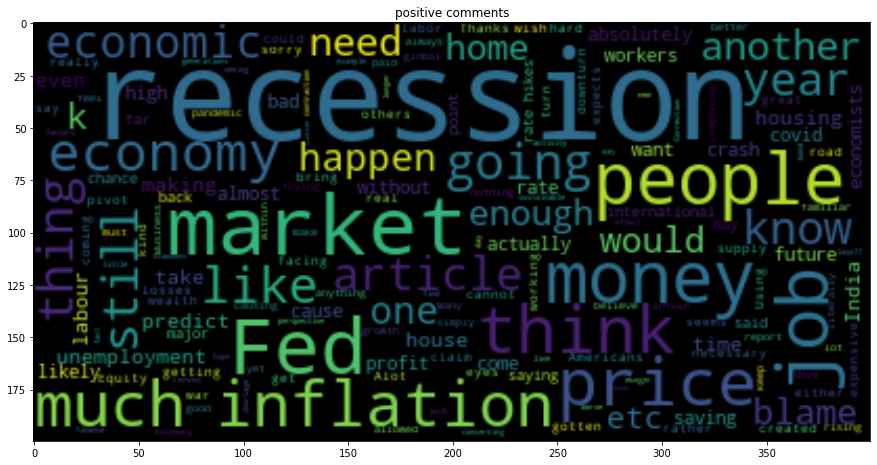

In [ ]:
from wordcloud import WordCloud
text_pos = " ".join(x for x in pos_join)
wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(text_pos)
plt.figure(figsize=(15,15))
plt.title('positive comments')
plt.imshow(wordcloud, interpolation='bilinear')

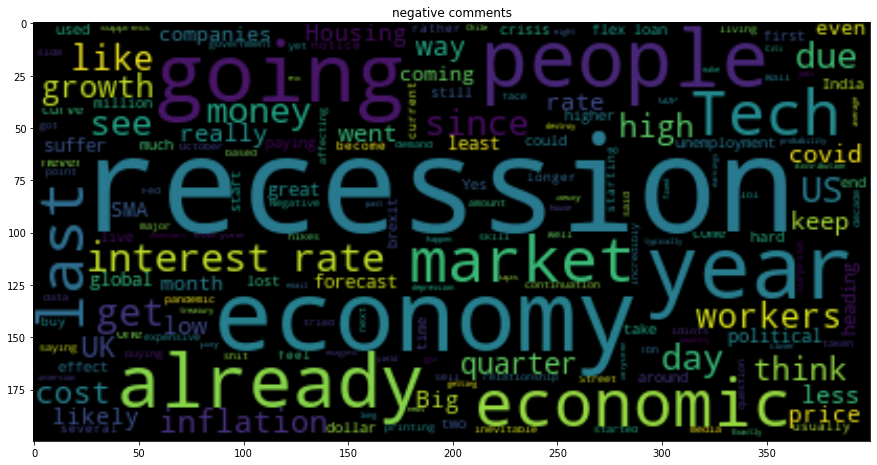

In [ ]:
from wordcloud import WordCloud
text_neg = " ".join(x for x in neg_join)
wordcloud = WordCloud(stopwords=stopwords.words('english')).generate(text_neg)
plt.figure(figsize=(15,15))
plt.title('negative comments')
plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
lem = WordNetLemmatizer()

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
re.sub('[^a-zA-Z]',' ',messages['Comments'][0])

'This has become a game of semantics  We re in a particularly turbulent political economic environment that is combining elements of recession with those of a strong labor market in a way not really seen in modern times   at least within the US  Whether it is a recession or not is up to an obscure board to determine   usually post hoc  Indeed  once we re  officially  in a recession  it will have already been going on for several quarters   I really wish there was more focus on the unique nature of the current market and global political economy rather than trying to shove it into preconceived holes that no longer line up with reality '

In [ ]:
clean_data = []
for i in range(len(messages)):
    sent = re.sub('[^a-zA-Z]',' ',messages['Comments'][i])
    sent = sent.lower()
    sent = sent.split()
    sent = [lem.lemmatize(word) for word in sent if word not in stopwords.words('english')]
    sent = ' '.join(sent)
    clean_data.append(sent)
    #if i%1000==0:
    #    print(i)

In [ ]:
count = {}
for i in clean_data:
  for j in i.split():
    if j in count.keys():
      count[j]+=1
    else:
      count[j]=1

In [ ]:
w_count = []
for r in sorted(count, key=count.get, reverse=True):
    w_count.append((r,count[r]))

In [ ]:
w_count[:15]

[('recession', 48),
 ('economy', 18),
 ('market', 17),
 ('year', 16),
 ('going', 13),
 ('people', 12),
 ('think', 11),
 ('rate', 10),
 ('money', 10),
 ('like', 9),
 ('much', 9),
 ('job', 9),
 ('tech', 9),
 ('economic', 8),
 ('already', 8)]

In [ ]:
counts_nsw = collections.Counter(clean_data)
counts_nsw.most_common(15)

[('become game semantics particularly turbulent political economic environment combining element recession strong labor market way really seen modern time least within u whether recession obscure board determine usually post hoc indeed officially recession already going several quarter really wish focus unique nature current market global political economy rather trying shove preconceived hole longer line reality',
  1),
 ('telling going alaskan bull worm starting notice theme economy great worker suffer great worker suffer forecast correct regular people get laid rich buy asset cheap economics starting feel like pretext ongoing abusive relationship',
  1),
 ('inflation already heading unemployment u low due baby boomer retirement covid death interest rate hike taken effect yet economy already heading towards recession fed horribly mismanaged already',
  1),
 ('wish like tbh recession becoming absolutely necessary desperately need reset home still completely unaffordable grocery ridicu

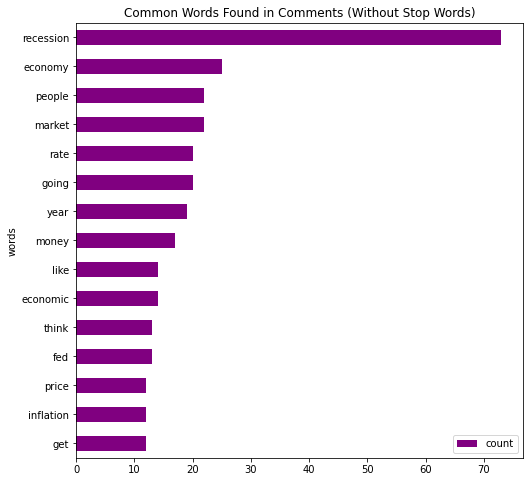

In [ ]:
clean_tweets_nsw = pd.DataFrame(w_count[:15],
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Comments (Without Stop Words)")

plt.show()

## 3) Converting words into Vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=5000)

In [ ]:
X = tf.fit_transform(clean_data).toarray()

In [ ]:
X = pd.concat([pd.DataFrame(X),messages['length']],axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [ ]:
y = pd.get_dummies(messages['Sentiment'],drop_first=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Thank you